# House_Price_Prediction 추가

In [10]:
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['font.family'] ='NanumGothic'
plt.rcParams['axes.unicode_minus'] =False

In [6]:
import os
                        
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, InvertibleMapper, StaticCovariatesTransformer
from darts.dataprocessing.transformers.missing_values_filler import MissingValuesFiller
from darts.metrics import rmsle
from darts.models import LinearRegressionModel, LightGBMModel, XGBModel, CatBoostModel
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tqdm.notebook import tqdm_notebook

plt.style.use("ggplot")
plt.rcParams["font.size"] = 15
COLORS = list(sns.color_palette())

c:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\dev\env_12\Lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\dev\env_12\Lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
c:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\dev\env_12\Lib\site-packages\dask\dataframe\utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


### Loading the datasets.

In [7]:
PATH = r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data"

train = pd.read_csv(os.path.join(PATH, "train.csv")) # (1118822, 52)
test = pd.read_csv(os.path.join(PATH, "test.csv")) # (9272, 51)
train_test = pd.read_csv(os.path.join(PATH, "train_test.csv")) # (1128094, 53)
subway_feature = pd.read_csv(os.path.join(PATH, "subway_feature.csv"))
sample_submission = pd.read_csv(os.path.join(PATH, "sample_submission.csv"))
bus_feature = pd.read_csv(os.path.join(PATH, "bus_feature.csv"))
seoul_apart = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\seoul_apart.csv", encoding='utf-8') # (2792, 47)
# 출처: https://data.seoul.go.kr/dataList/OA-15818/S/1/datasetView.do 서울시 공동주택 아파트 정보
doroaddress = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\doroaddress.csv", encoding='utf-8') # (8325, 7)
bunjiaddress = pd.read_csv(r"C:\Users\user\upstage3-python\12.upstage_project_House_Price_Prediction\asset\data\bunjiaddress.csv", encoding='utf-8') # (8954, 1) 
# 출처: https://www.juso.go.kr/CommonPageLink.do?link=/support/AddressTransform 100만건 이하 주소전환

C:\Users\user\AppData\Local\Temp\ipykernel_9188\3151250873.py:3: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(os.path.join(PATH, "train.csv")) # (1118822, 52)
C:\Users\user\AppData\Local\Temp\ipykernel_9188\3151250873.py:5: DtypeWarning: Columns (16,17,36) have mixed types. Specify dtype option on import or set low_memory=False.
  train_test = pd.read_csv(os.path.join(PATH, "train_test.csv")) # (1128094, 53)


# EDA

### 층별에 따른 아파트 가격 차이가 없다.

In [484]:
show.층.unique()

array([3, 4, 5, 2, 1], dtype=int64)

In [489]:
train_test.아파트명.unique()

array(['개포6차우성', '개포우성3차', '개포자이', ..., '히페리온리버팰리스', '세운푸르지오헤리시티',
       '힐스테이트세운센트럴1단지'], dtype=object)

C:\Users\user\AppData\Local\Temp\ipykernel_22368\3471685677.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  show['계약년월일'] = pd.to_datetime(show['계약년월일'])  # 계약년월일을 datetime 객체로 변환


Text(0, 0.5, 'Target')

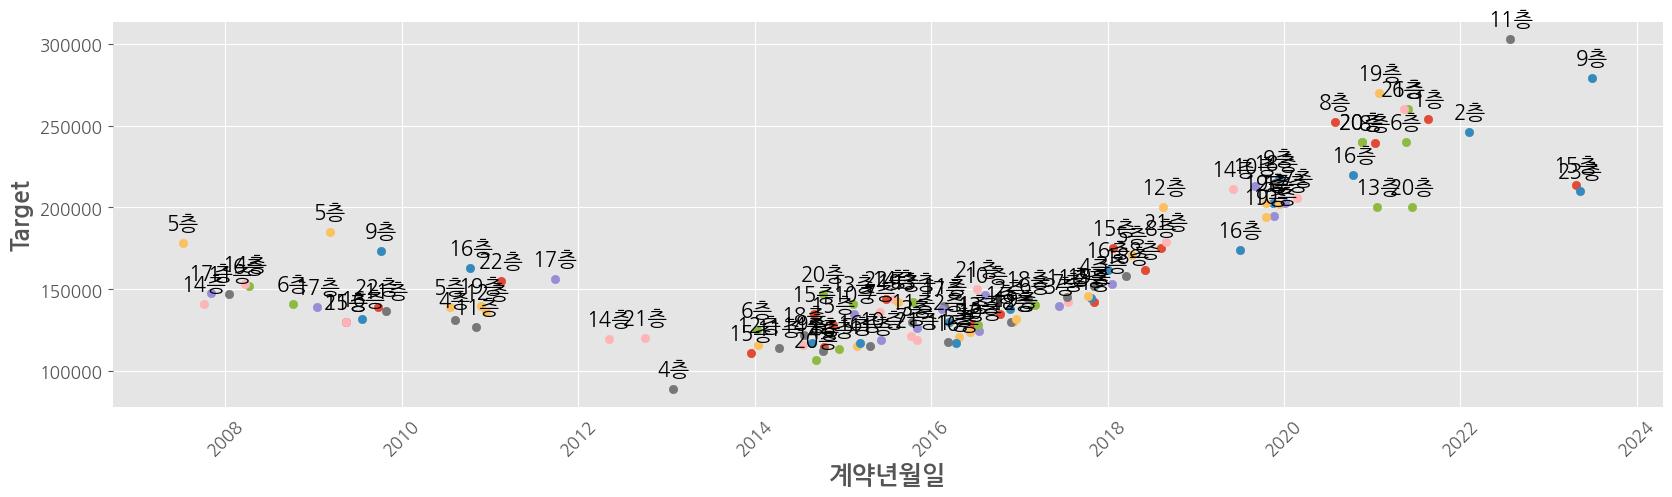

In [503]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# 데이터 처리 부분
filtered = train_test[train_test.아파트명.str.contains('개포자이')==True]
show = filtered[['id', '계약년월일','target','is_test','층']]
show['계약년월일'] = pd.to_datetime(show['계약년월일'])  # 계약년월일을 datetime 객체로 변환

# 그래프 그리기 부분
plt.figure(figsize=(20, 5))

# 층별로 다른 색상과 선 스타일로 플롯
apartfloor = show.층.unique().max()
for floor in range(1, apartfloor + 1):  # 층 범위 수정: apartfloor + 1로 변경
    subset = show[(show.is_test == 0) & (show.층 == floor)]
    plt.scatter(subset['계약년월일'], subset['target'], label=f'층 {floor}')  # scatter로 변경

    # 각 데이터 포인트에 주석 추가
    for i in range(len(subset)):
        plt.annotate(f'{floor}층', (subset['계약년월일'].iloc[i], subset['target'].iloc[i]), 
                     textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)  # 그리드 활성화
plt.xticks(rotation=45)  # x축 레이블 회전
plt.xlabel('계약년월일')  # x축 레이블
plt.ylabel('Target')  # y축 레이블


### 구마다 아파트 평균 가격이 다르다

In [510]:
gu = train_test.구.unique()
gu

array(['강남구', '강동구', '강북구', '강서구', '관악구', '광진구', '구로구', '금천구', '노원구',
       '도봉구', '동대문구', '동작구', '마포구', '서대문구', '서초구', '성동구', '성북구', '송파구',
       '양천구', '영등포구', '용산구', '은평구', '종로구', '중구', '중랑구'], dtype=object)

In [520]:
train_test.계약년월일.min()
train_test.계약년월일.max()

Timestamp('2023-09-26 00:00:00')

C:\Users\user\AppData\Local\Temp\ipykernel_22368\1761913101.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


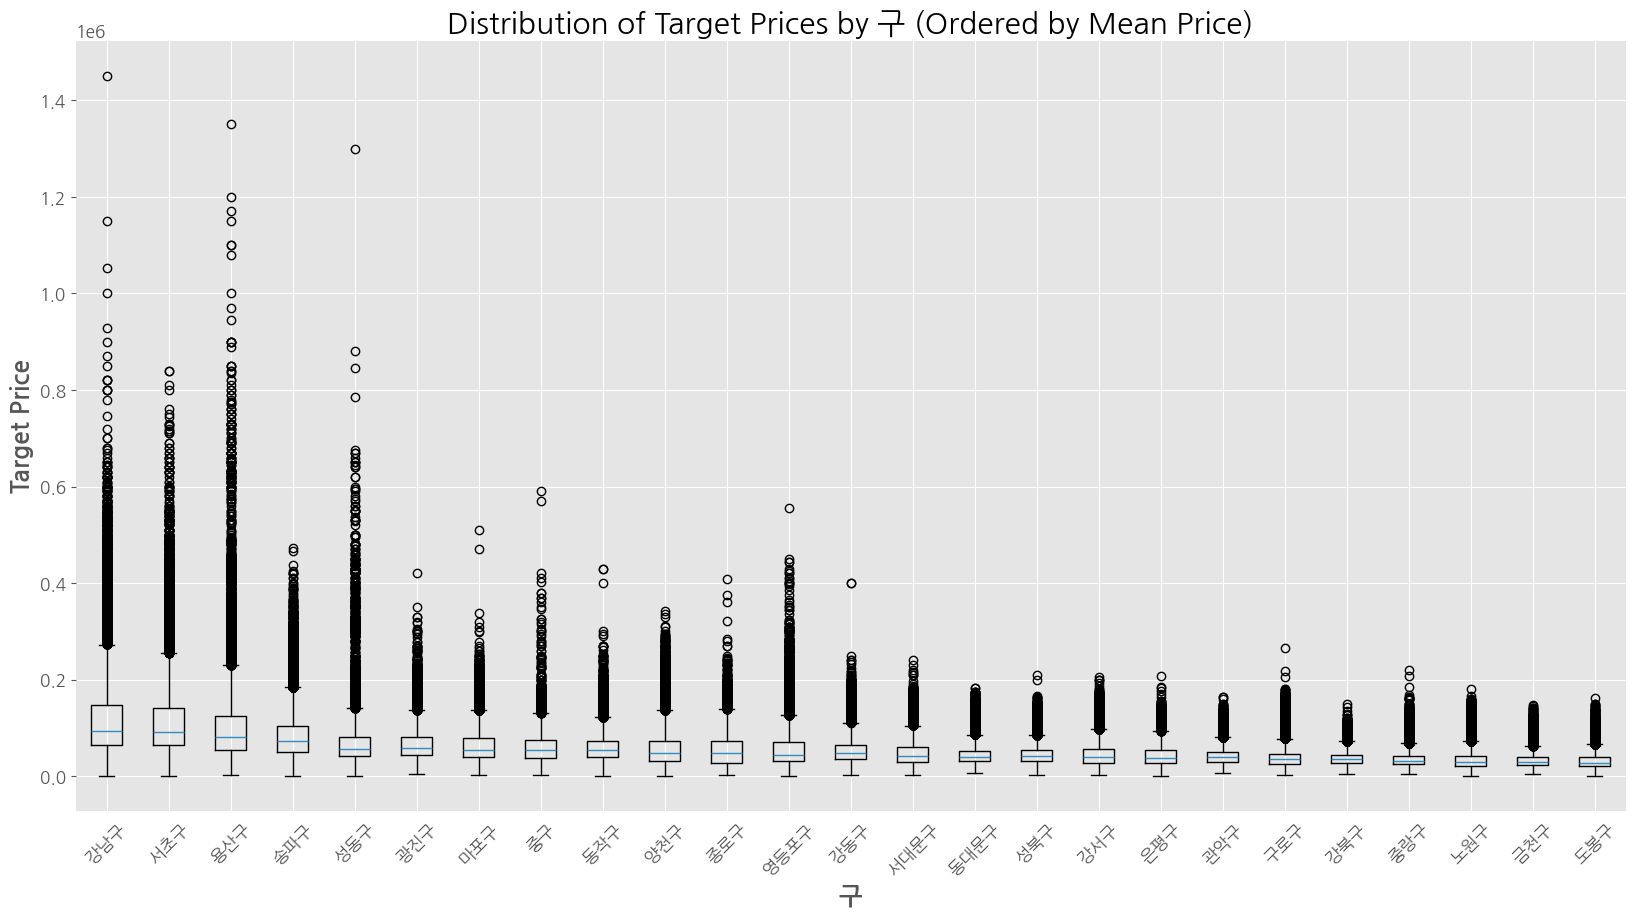

In [523]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
train_test['계약년월일'] = pd.to_datetime(train_test['계약년월일'])
filtered_df = train_test[(train_test['계약년월일'] >= '2007-01-01') & (train_test['계약년월일'] <= '2023-06-30')]

# '구'별로 평균 'target'을 계산하고 정렬
mean_targets = filtered_df.groupby('구')['target'].mean().sort_values(ascending=False)
sorted_gus = mean_targets.index  # 정렬된 '구' 목록

# 박스플롯 데이터 준비
boxplot_data = [filtered_df[filtered_df['구'] == gu]['target'] for gu in sorted_gus]

# 박스플롯 생성
plt.figure(figsize=(20, 10))
plt.boxplot(boxplot_data, labels=sorted_gus)
plt.xticks(rotation=45)  # x축 레이블 회전
plt.xlabel('구')
plt.ylabel('Target Price')
plt.title('Distribution of Target Prices by 구 (Ordered by Mean Price)')
plt.grid(True)
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_22368\123329465.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


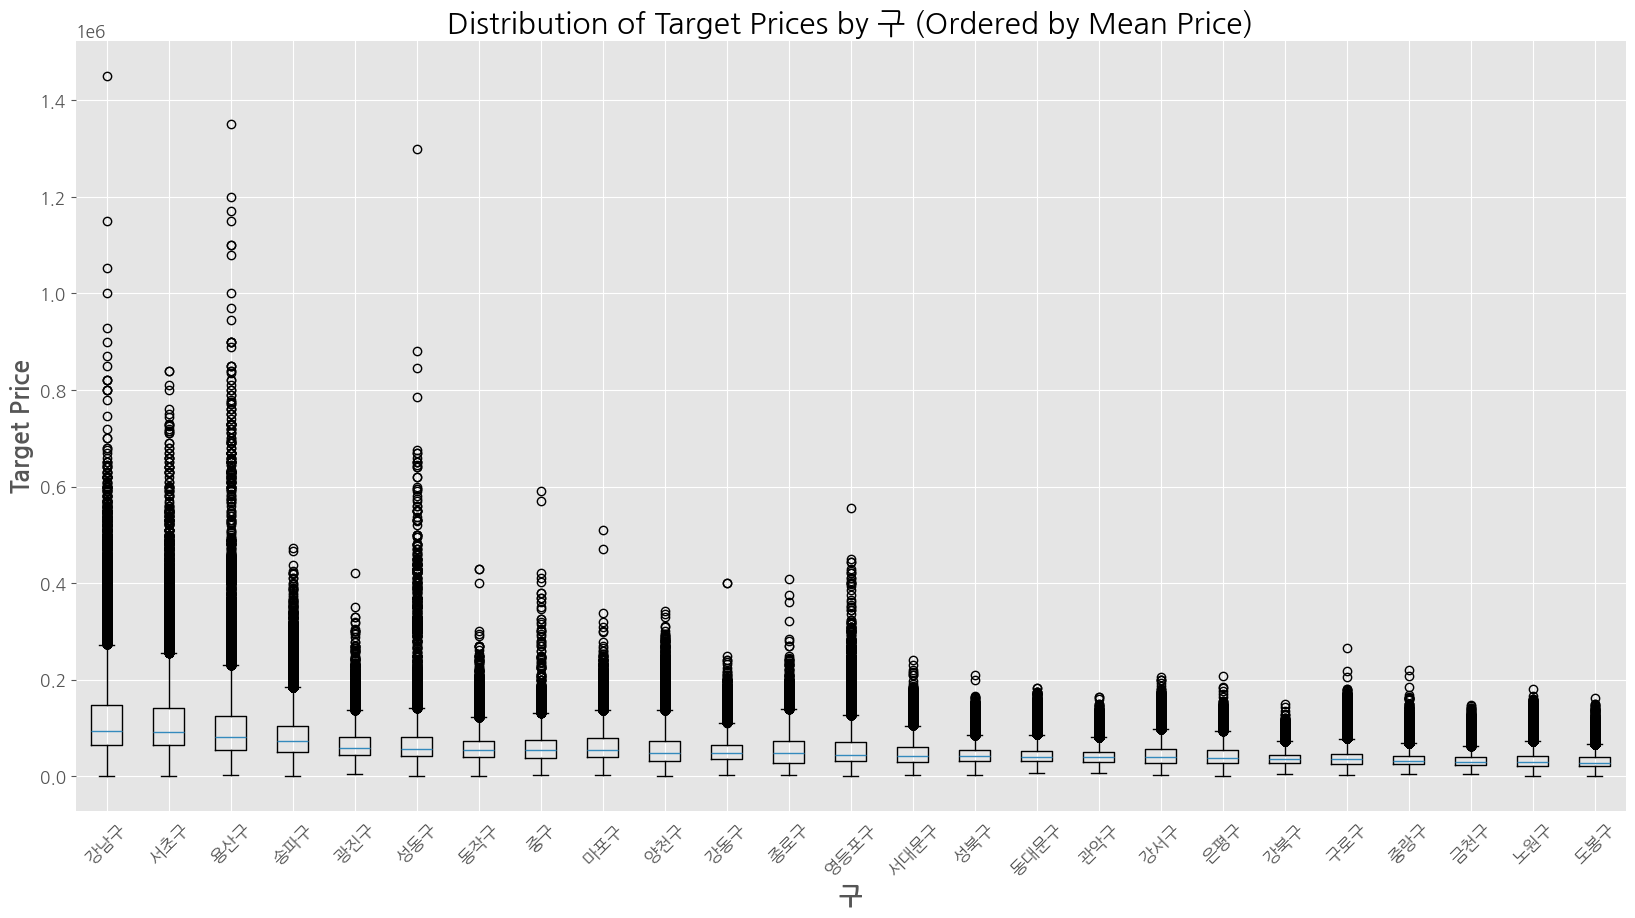

In [524]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
train_test['계약년월일'] = pd.to_datetime(train_test['계약년월일'])
filtered_df = train_test[(train_test['계약년월일'] >= '2007-01-01') & (train_test['계약년월일'] <= '2023-06-30')]

# '구'별로 평균 'target'을 계산하고 정렬
median_targets = filtered_df.groupby('구')['target'].median().sort_values(ascending=False)
sorted_gus = median_targets.index  # 정렬된 '구' 목록

# 박스플롯 데이터 준비
boxplot_data = [filtered_df[filtered_df['구'] == gu]['target'] for gu in sorted_gus]

# 박스플롯 생성
plt.figure(figsize=(20, 10))
plt.boxplot(boxplot_data, labels=sorted_gus)
plt.xticks(rotation=45)  # x축 레이블 회전
plt.xlabel('구')
plt.ylabel('Target Price')
plt.title('Distribution of Target Prices by 구 (Ordered by Mean Price)')
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
train_test['계약년월일'] = pd.to_datetime(train_test['계약년월일'])

# '구'별로 평균 'target'을 계산하고 정렬
median_targets = train_test.groupby('구')['target'].median().sort_values(ascending=False)
sorted_gus = median_targets.index  # 정렬된 '구' 목록

# 각 연도별로 데이터 필터링 및 박스플롯 생성
start_year = 2007
end_year = 2023
for year in range(start_year, end_year + 1):
    year_df = train_test[(train_test['계약년월일'].dt.year == year)]

    # 박스플롯 데이터 준비
    boxplot_data = [year_df[year_df['구'] == gu]['target'] for gu in sorted_gus]

    # 박스플롯 생성
    plt.figure(figsize=(20, 10))
    plt.boxplot(boxplot_data, labels=sorted_gus)
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.xlabel('구')
    plt.ylabel('Target Price')
    plt.title(f'Distribution of Target Prices by 구 for {year} (Ordered by Median Price)')
    plt.grid(True)
    plt.show()


In [ ]:
filtered = train_test[(train_test.구 =='강남구')&(train_test.계약년=='2017')]

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


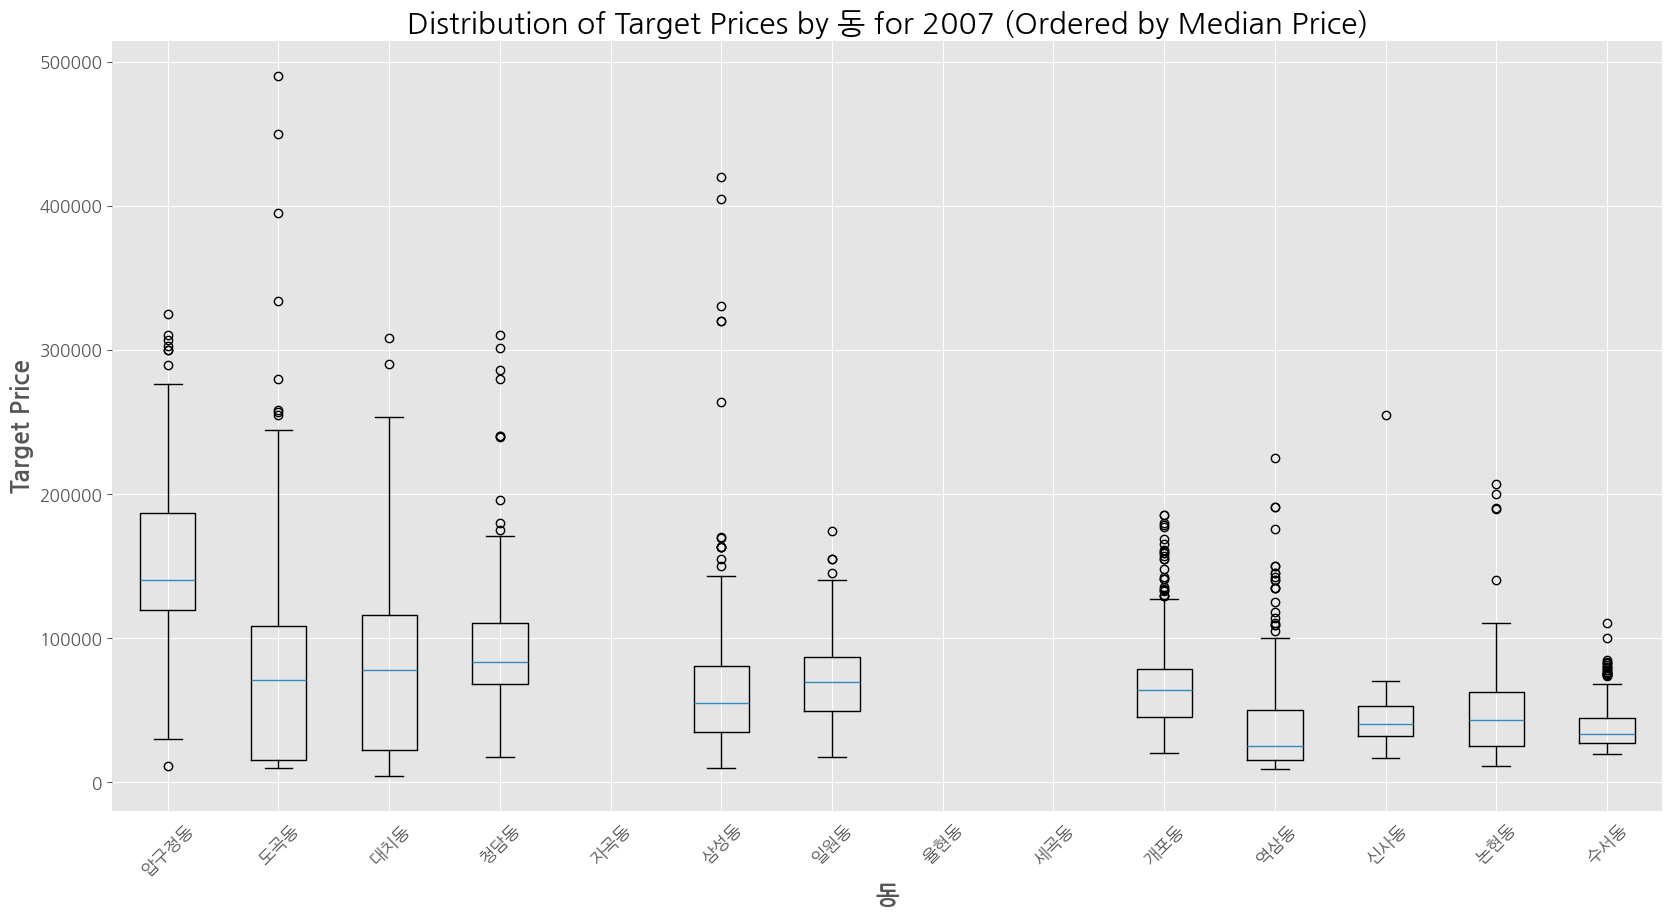

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


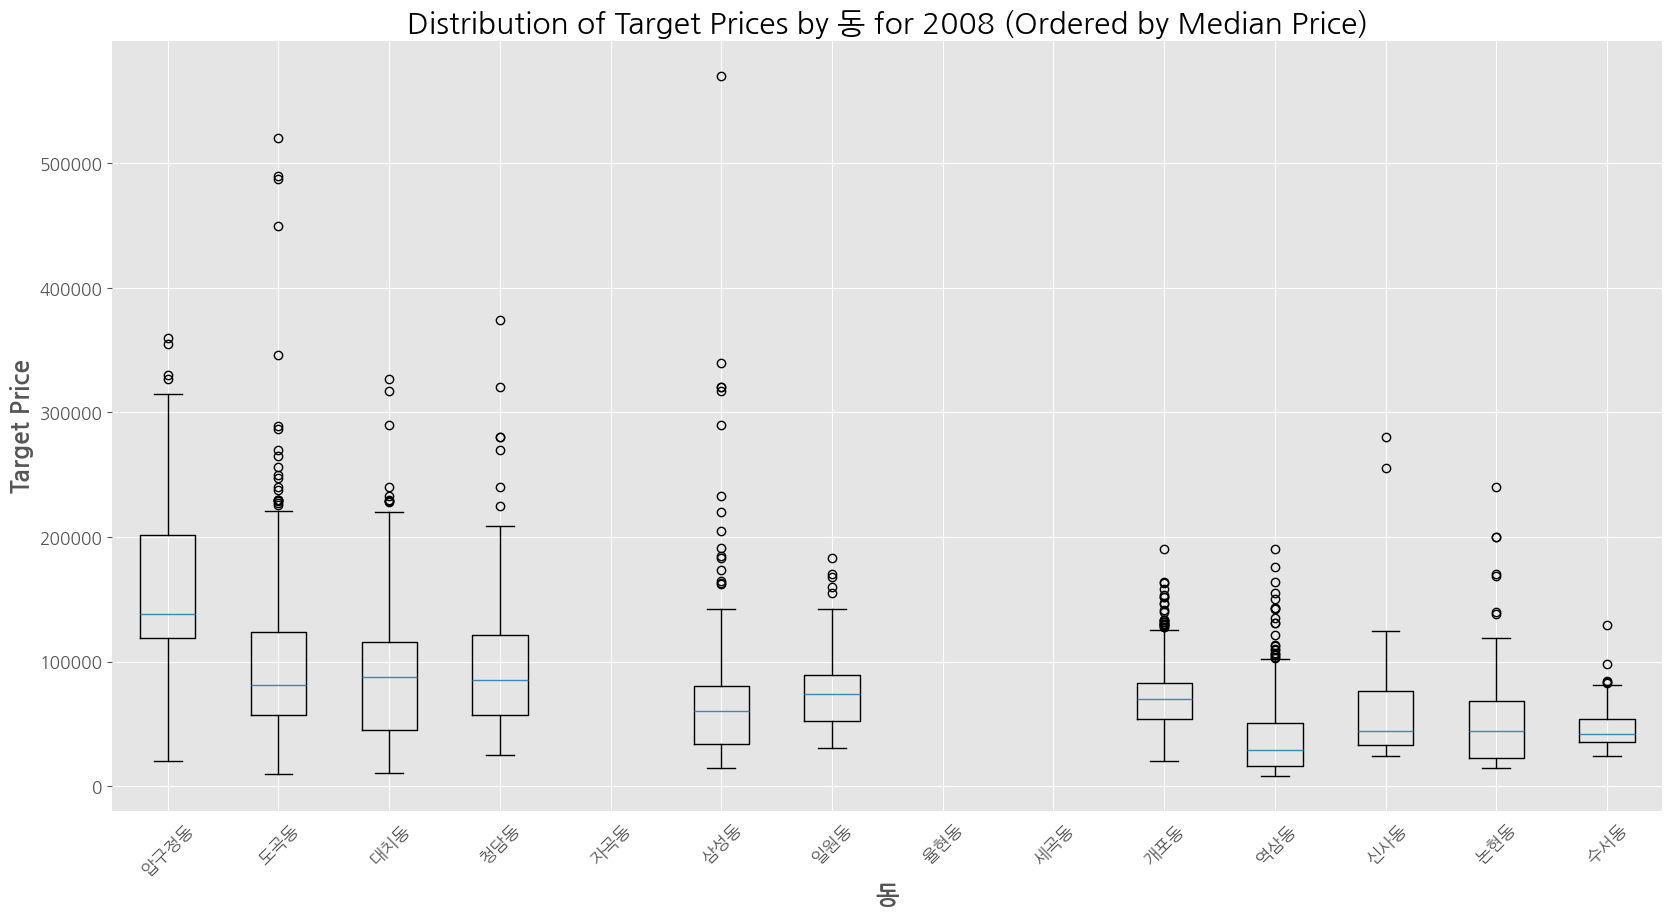

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


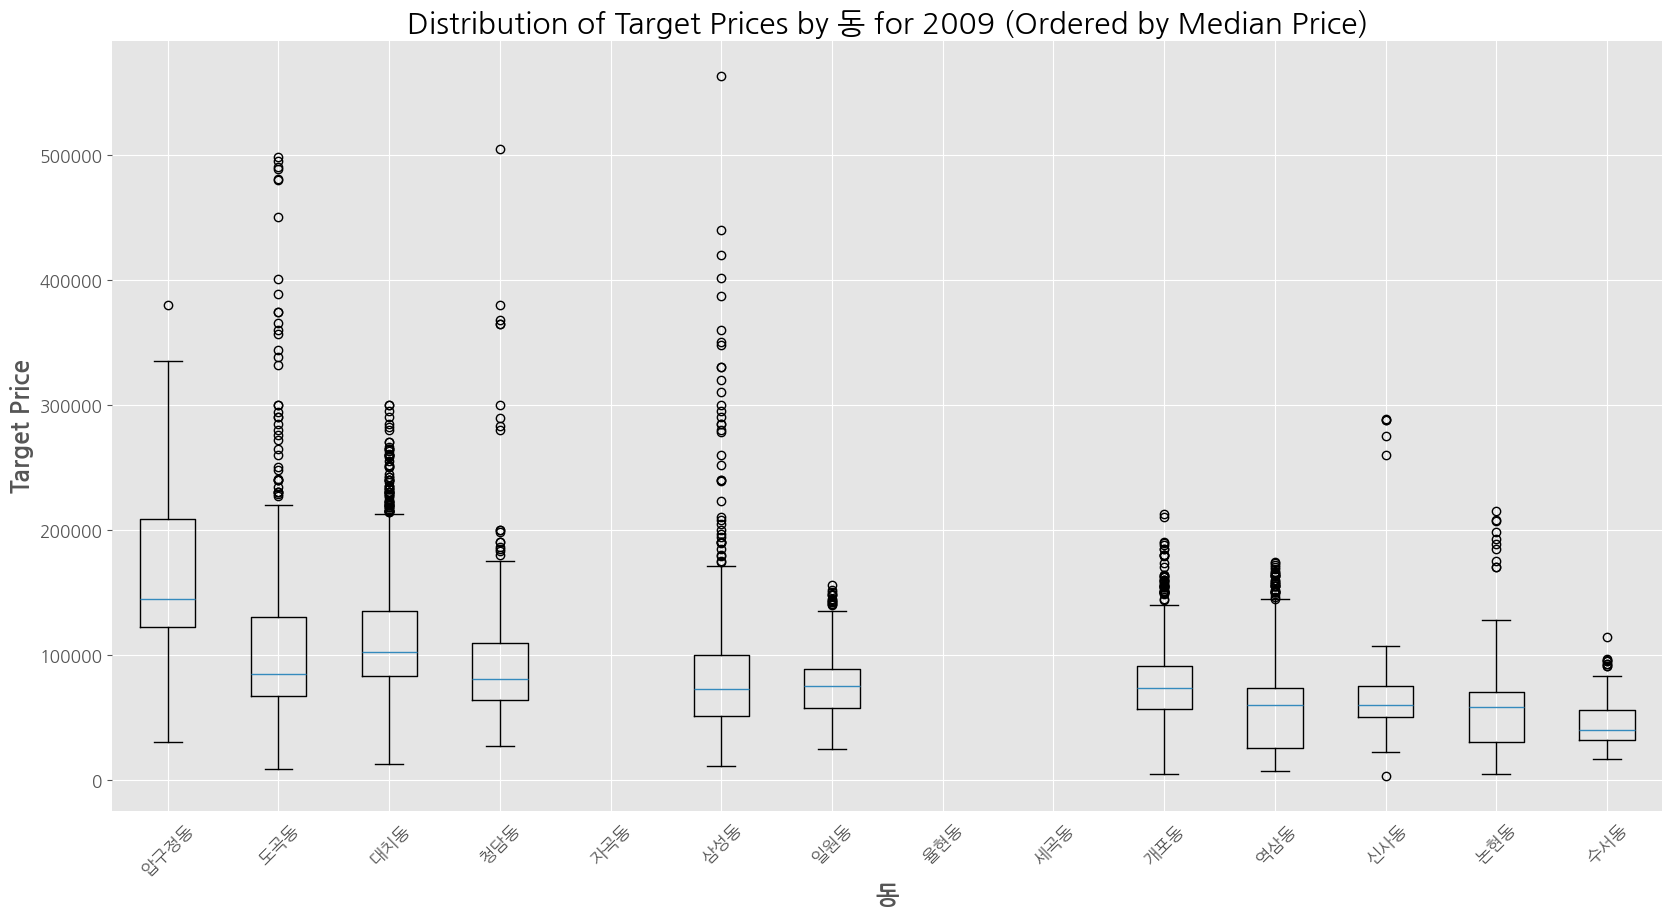

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


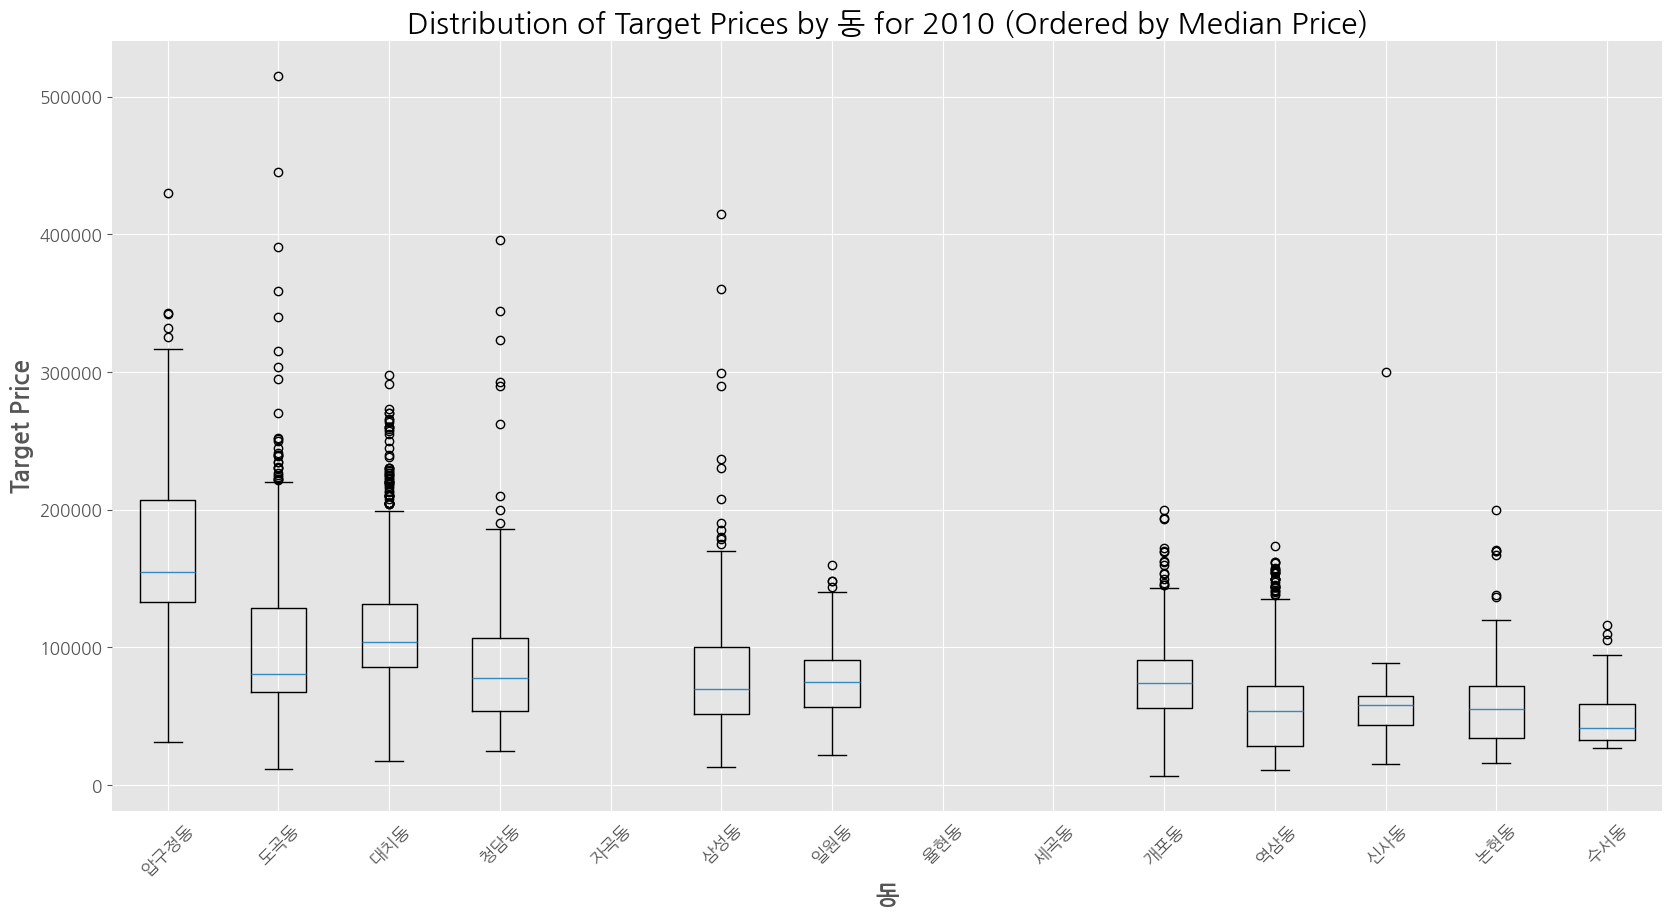

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


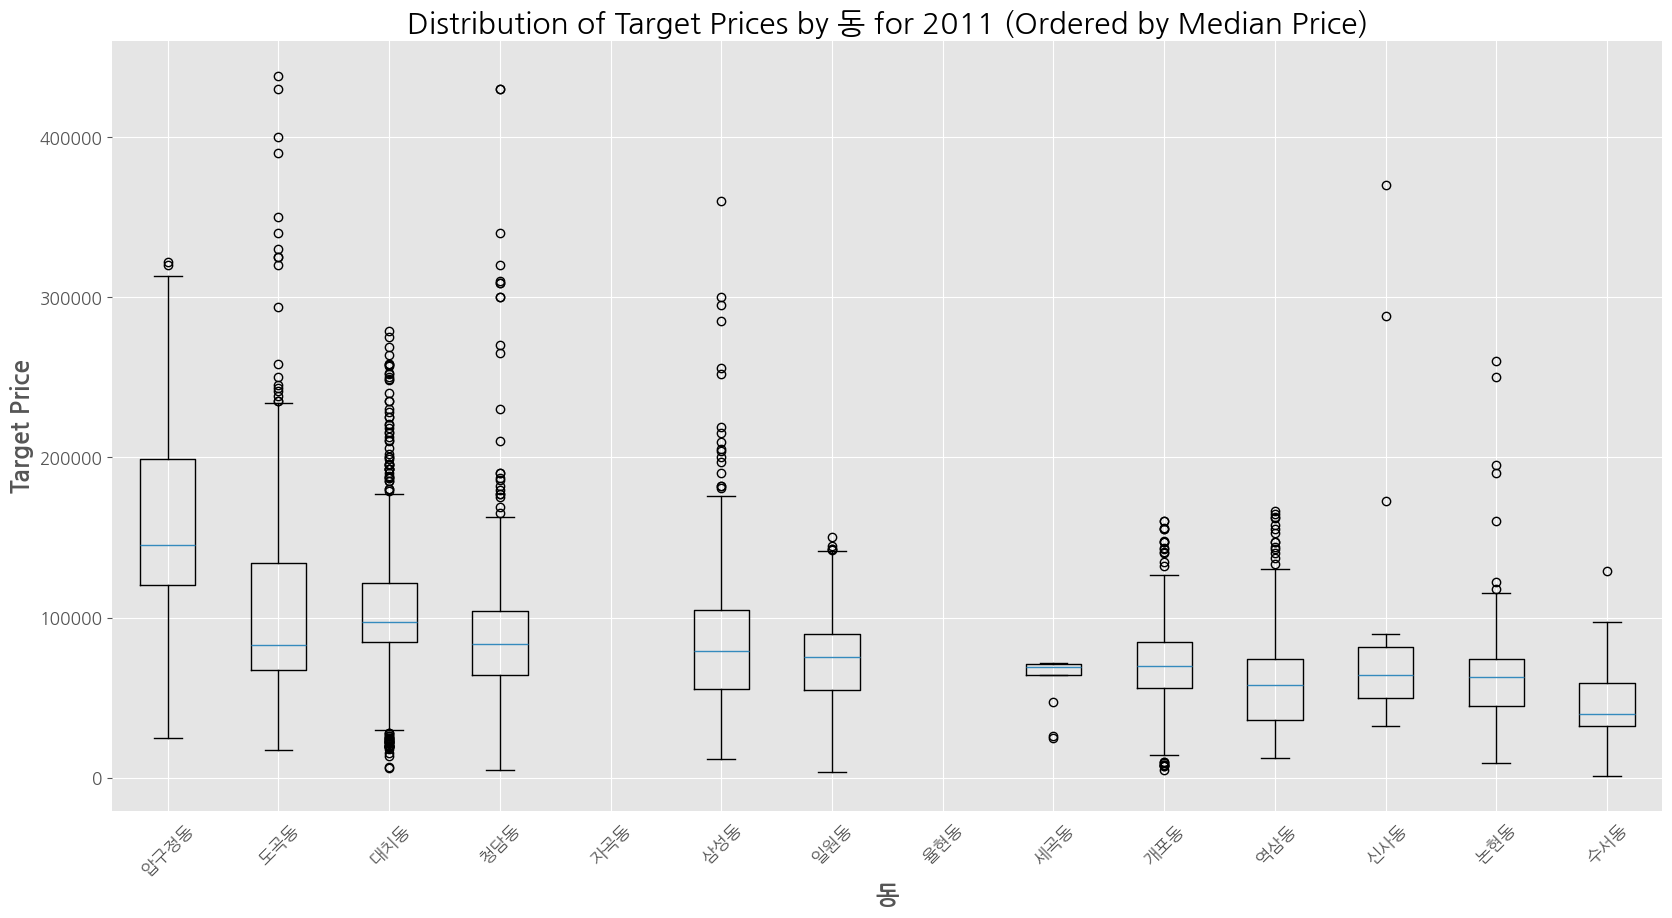

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


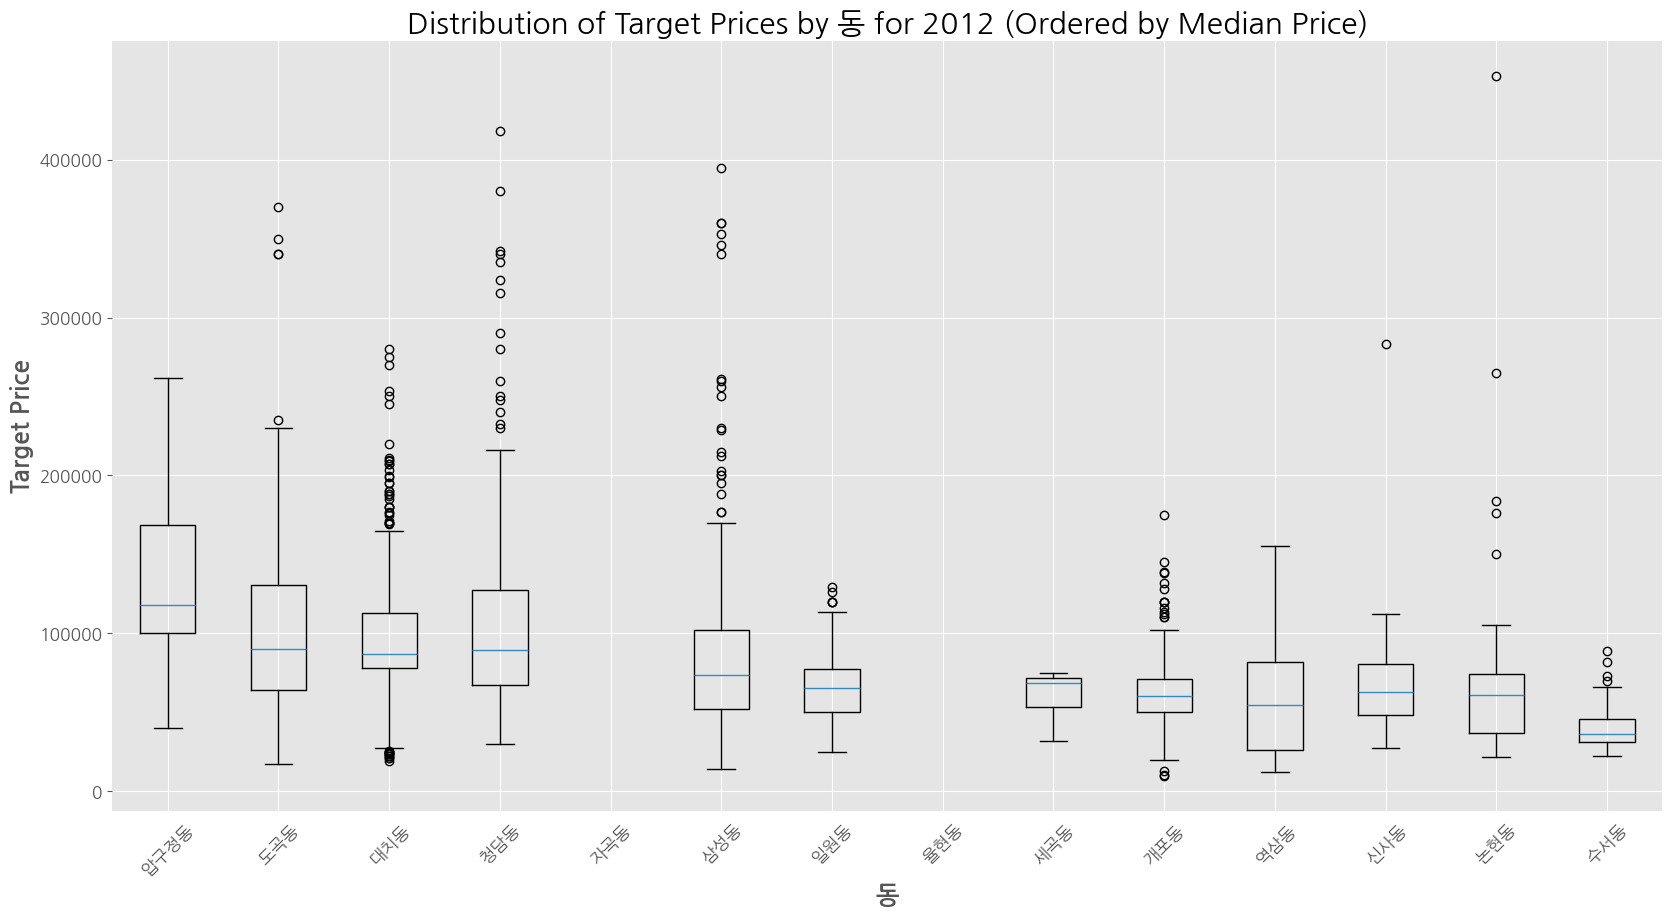

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


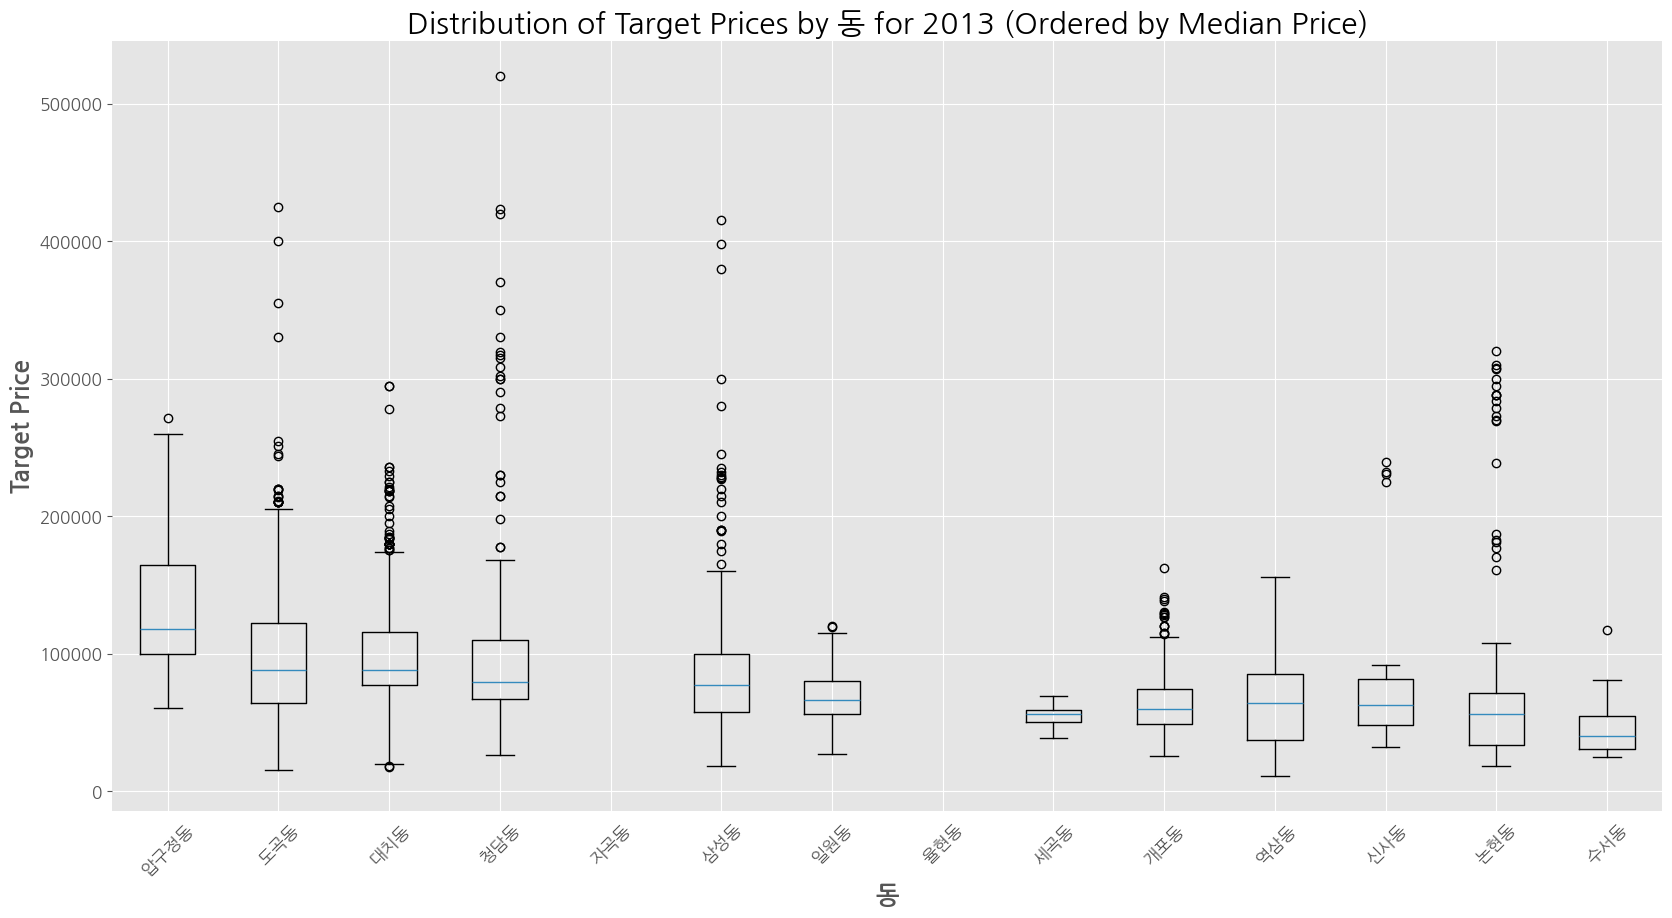

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


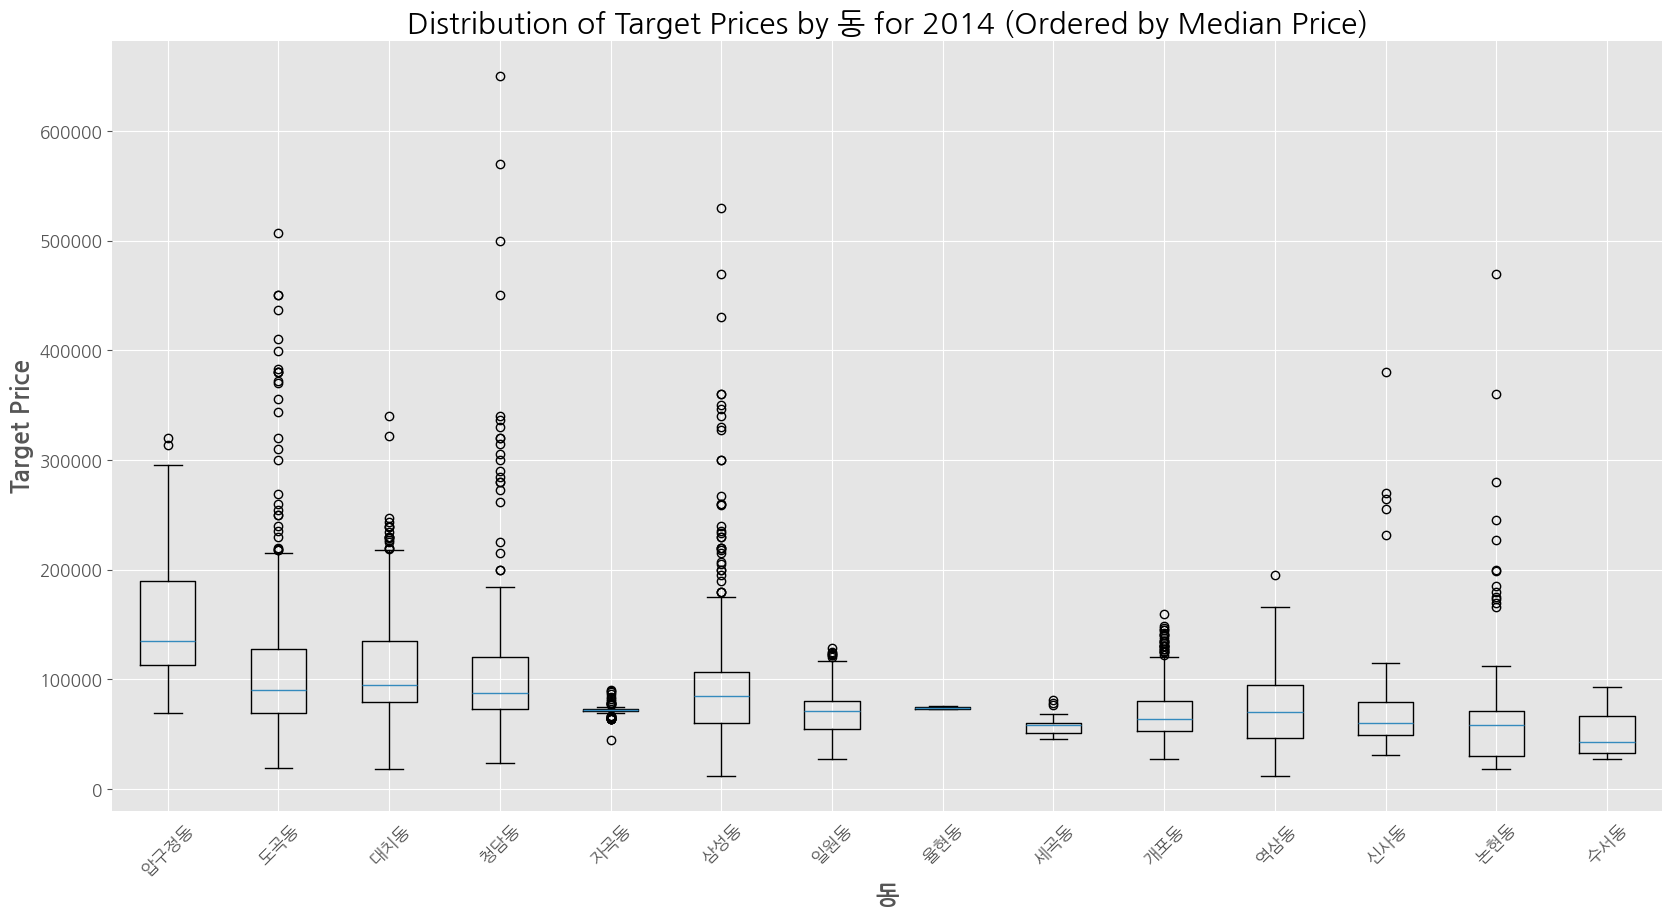

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


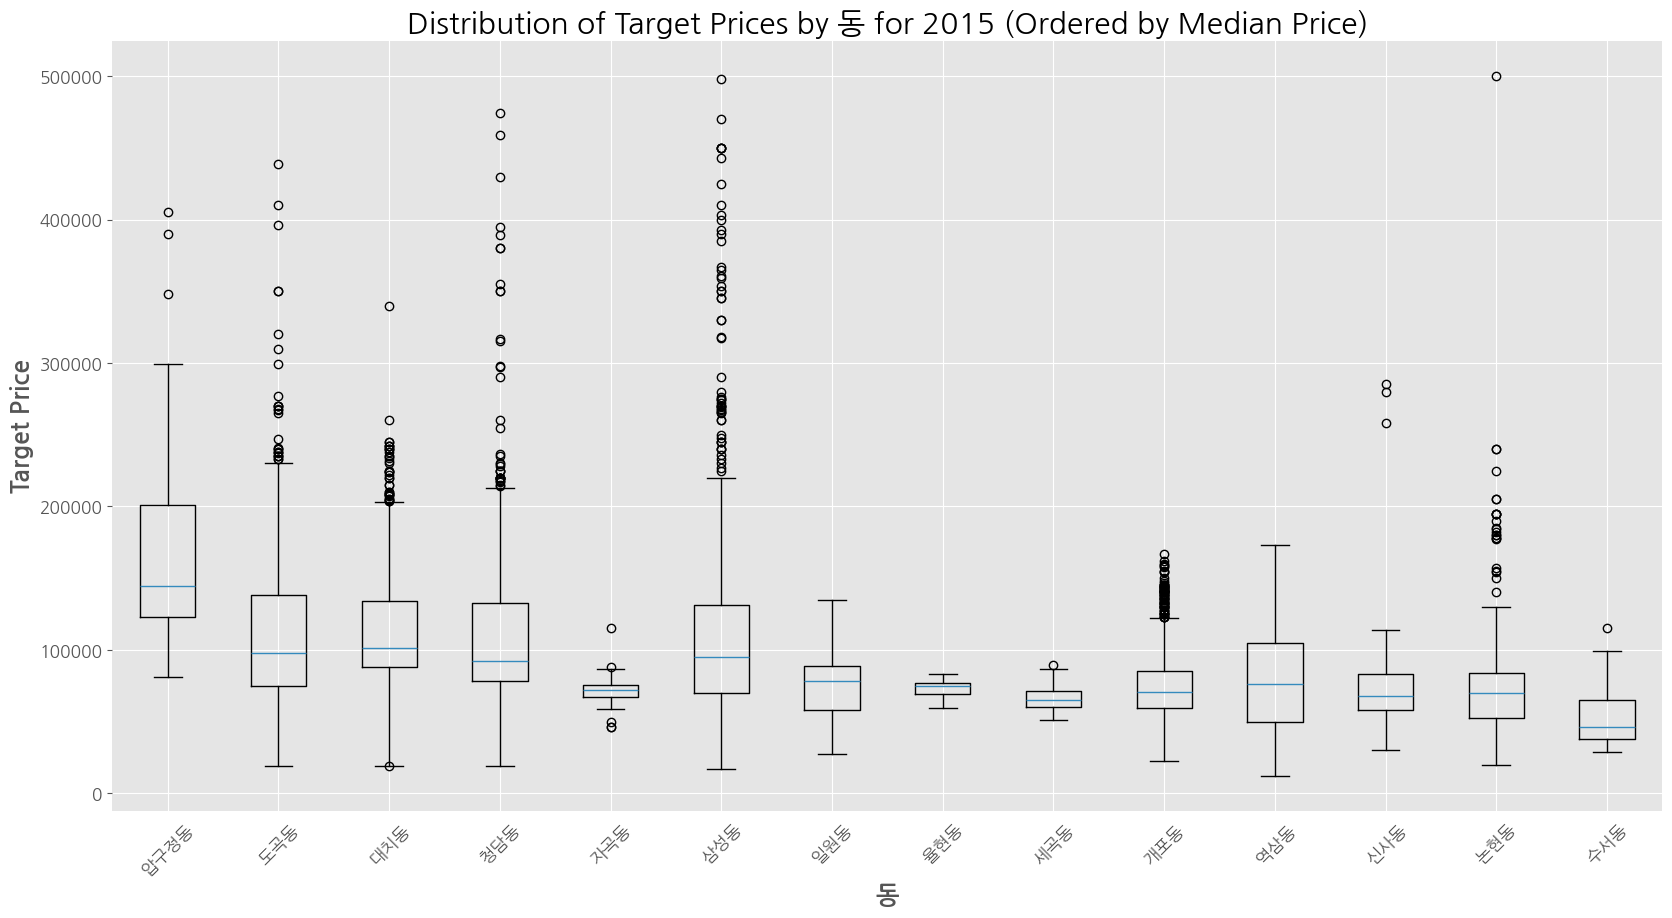

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


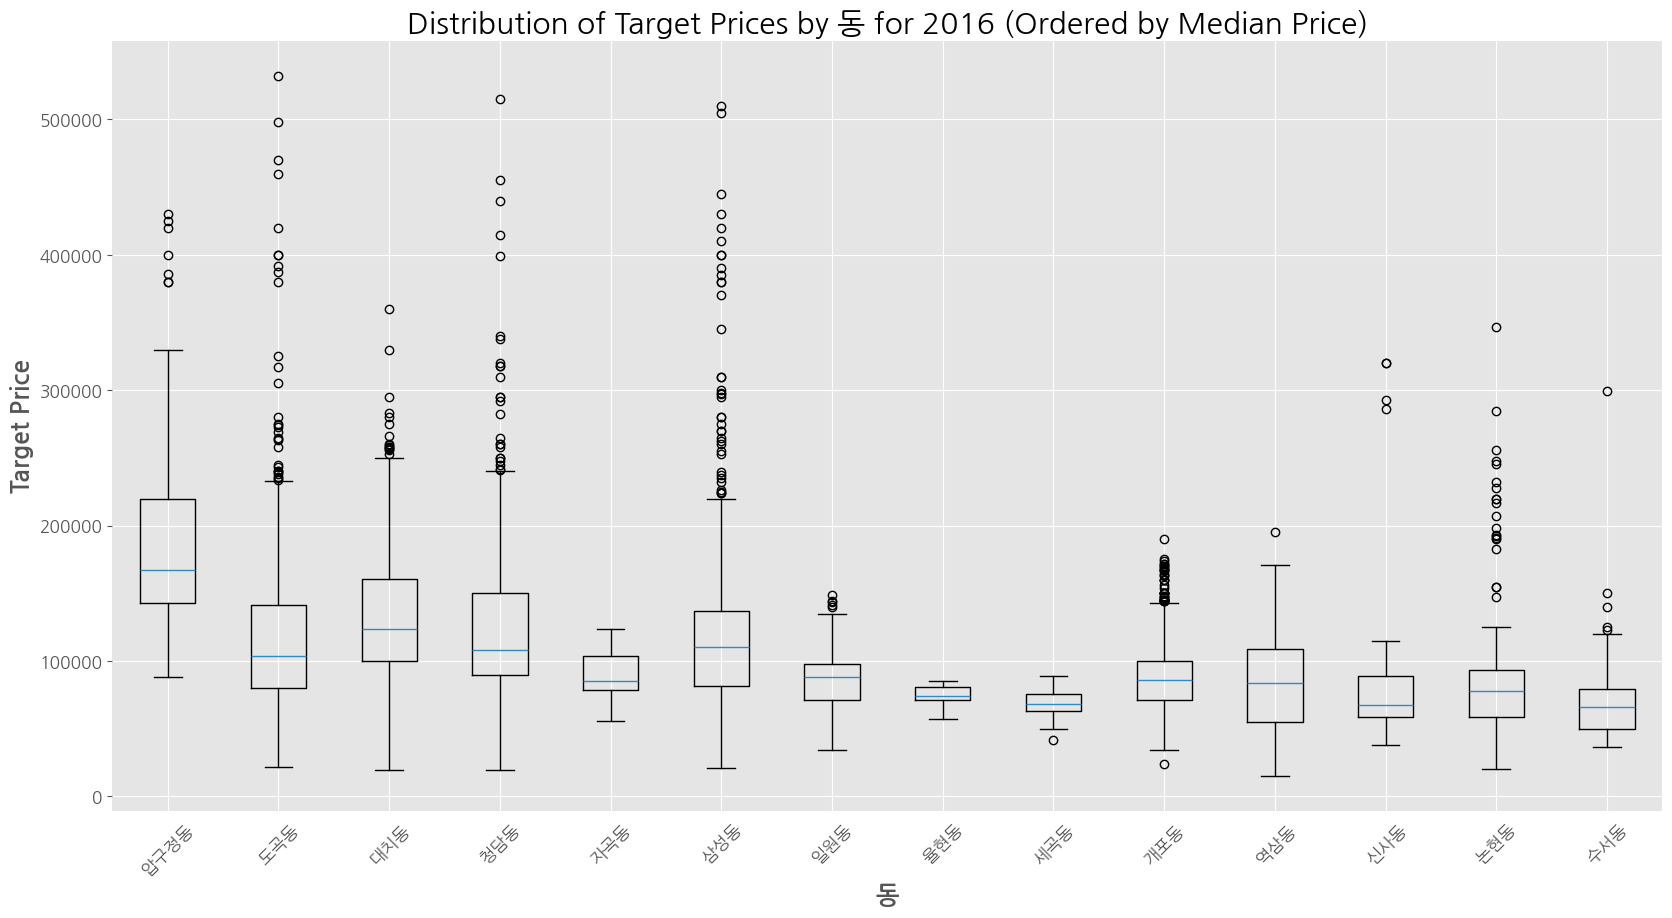

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


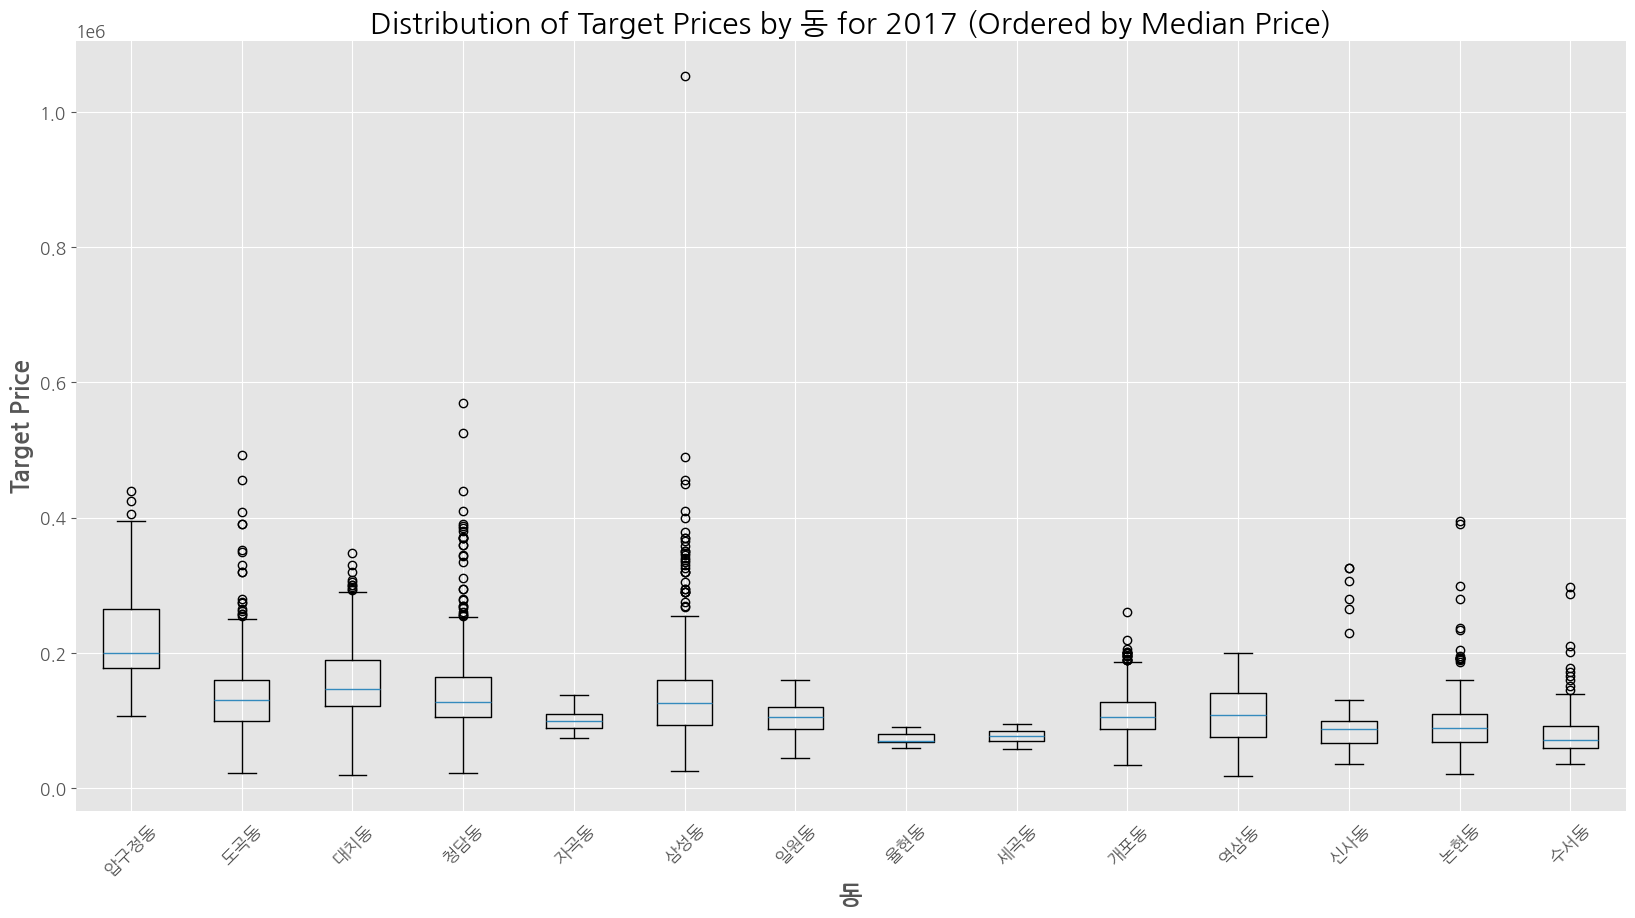

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


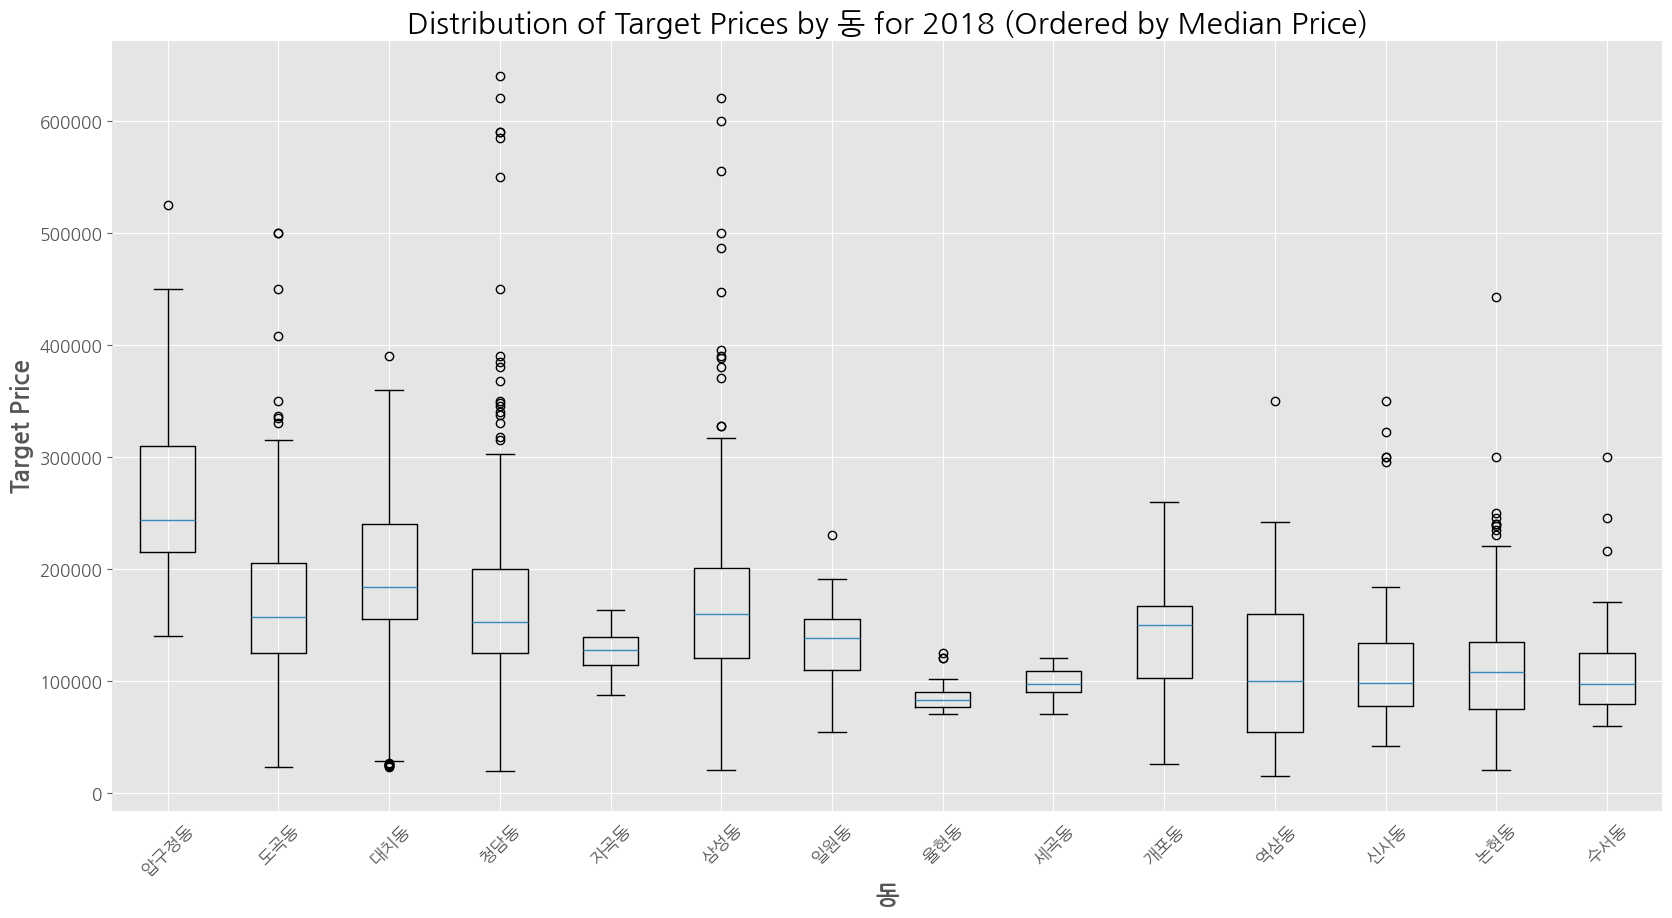

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


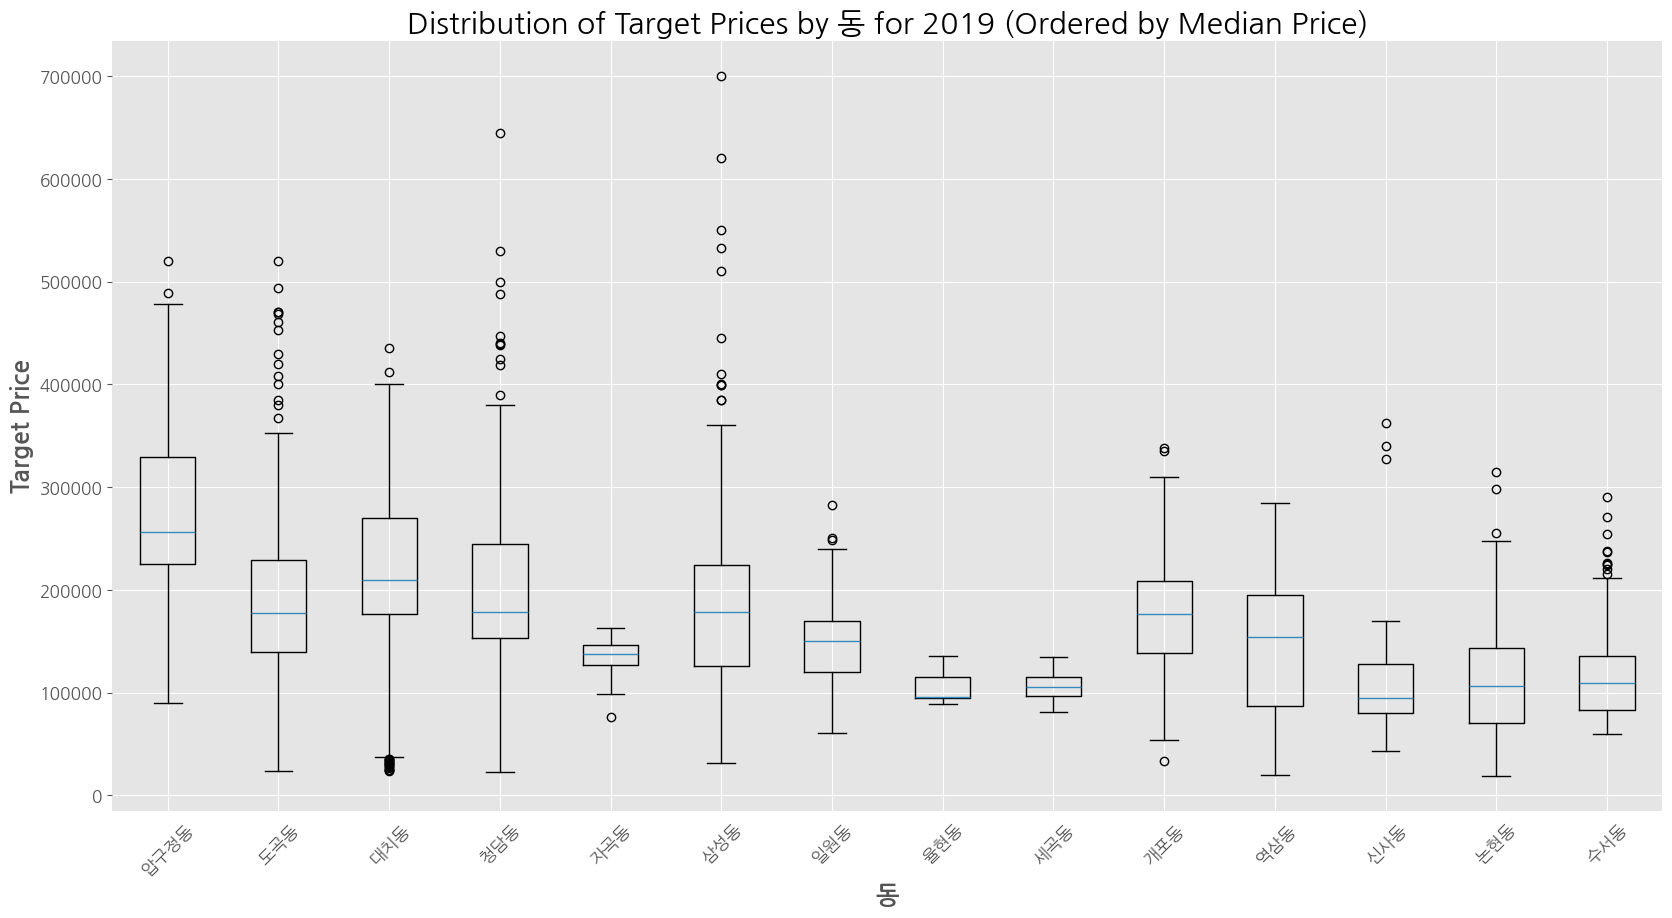

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


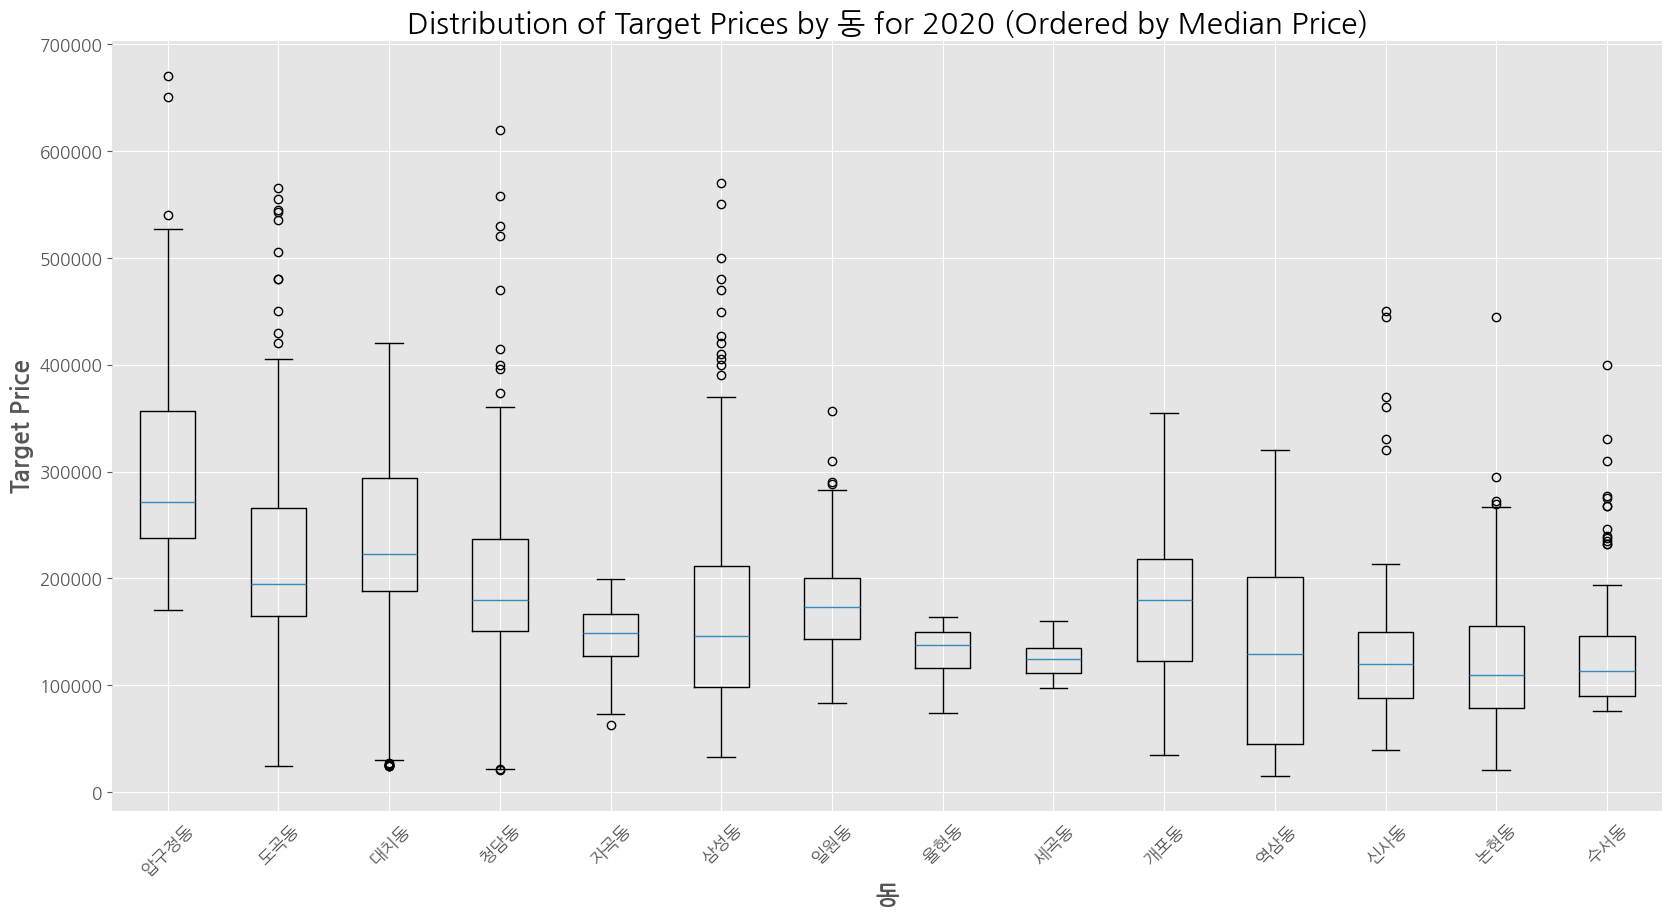

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


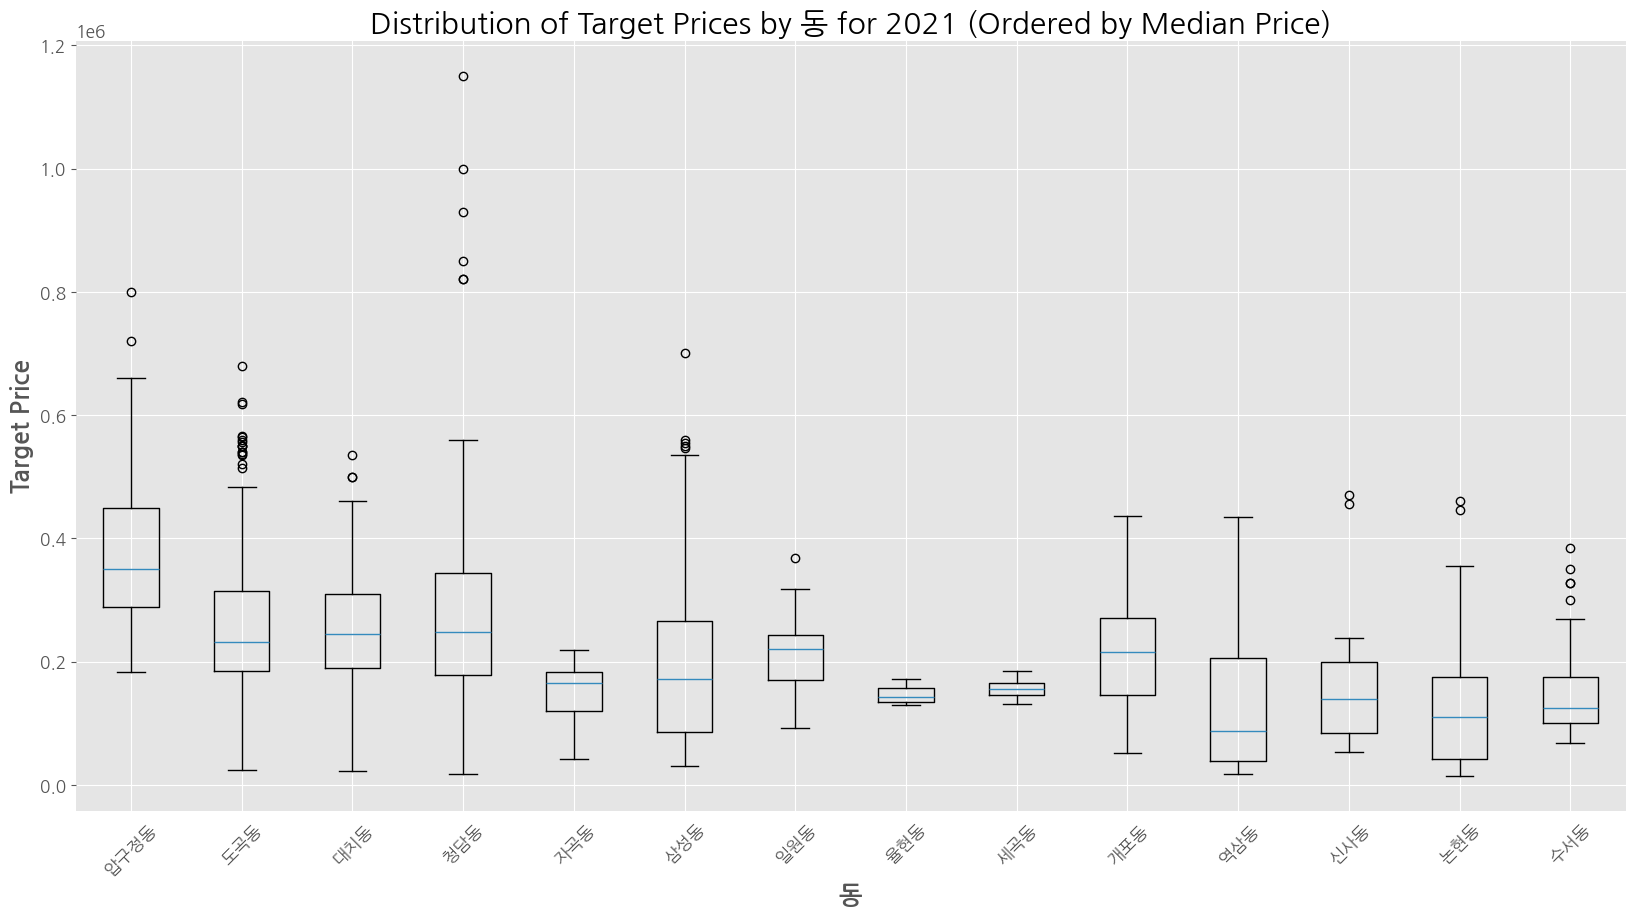

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


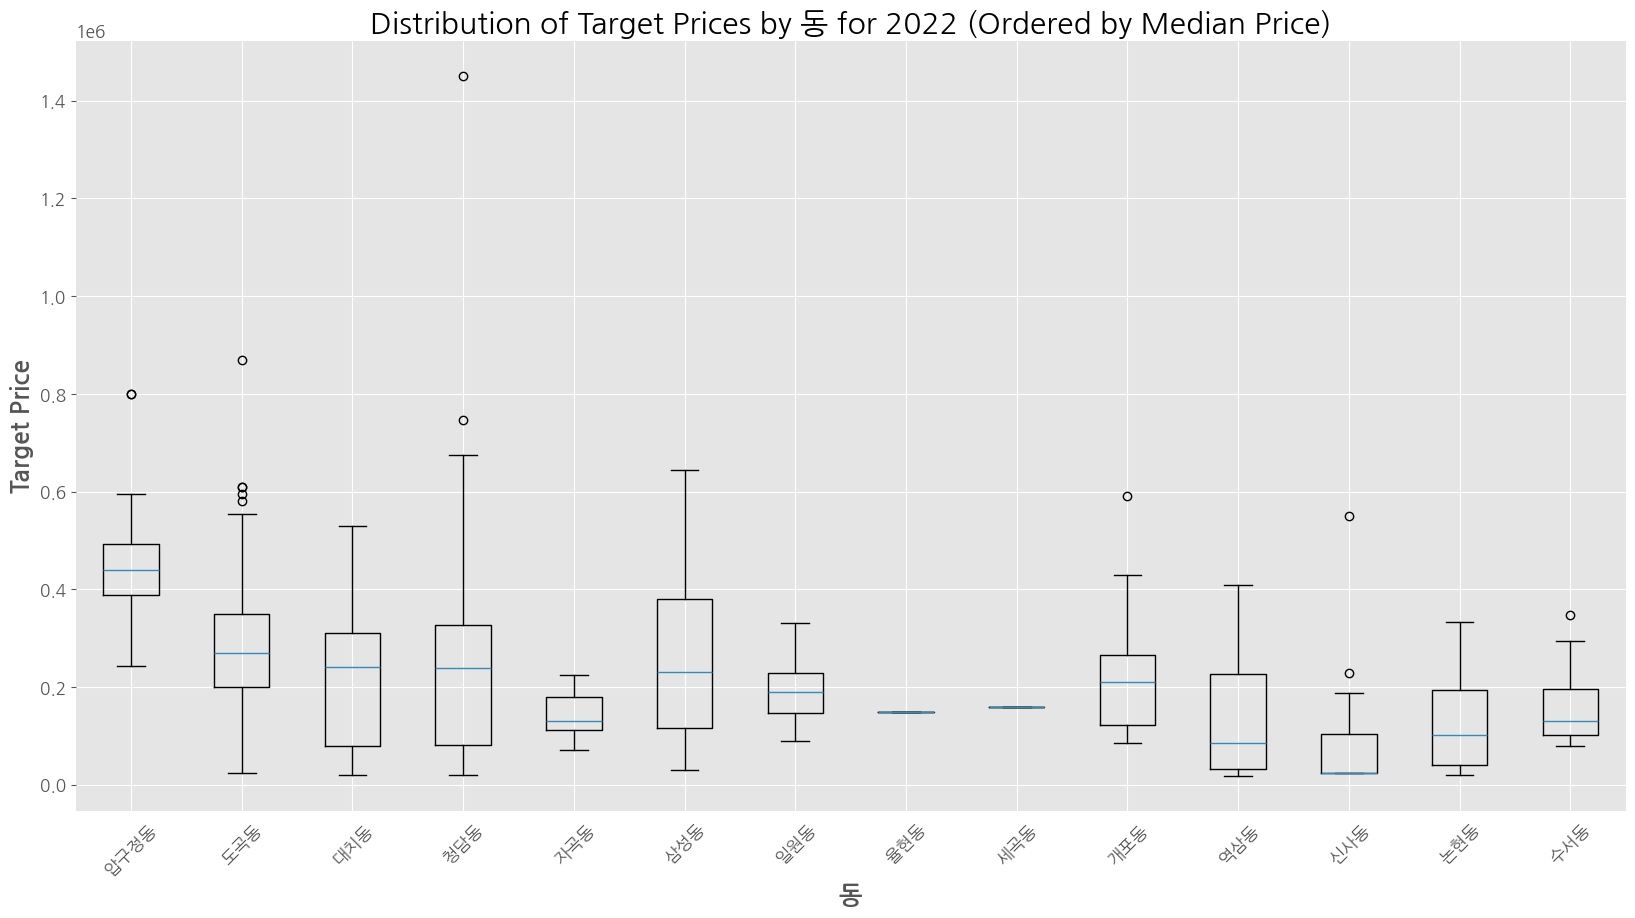

C:\Users\user\AppData\Local\Temp\ipykernel_22368\244769736.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=sorted_gus)


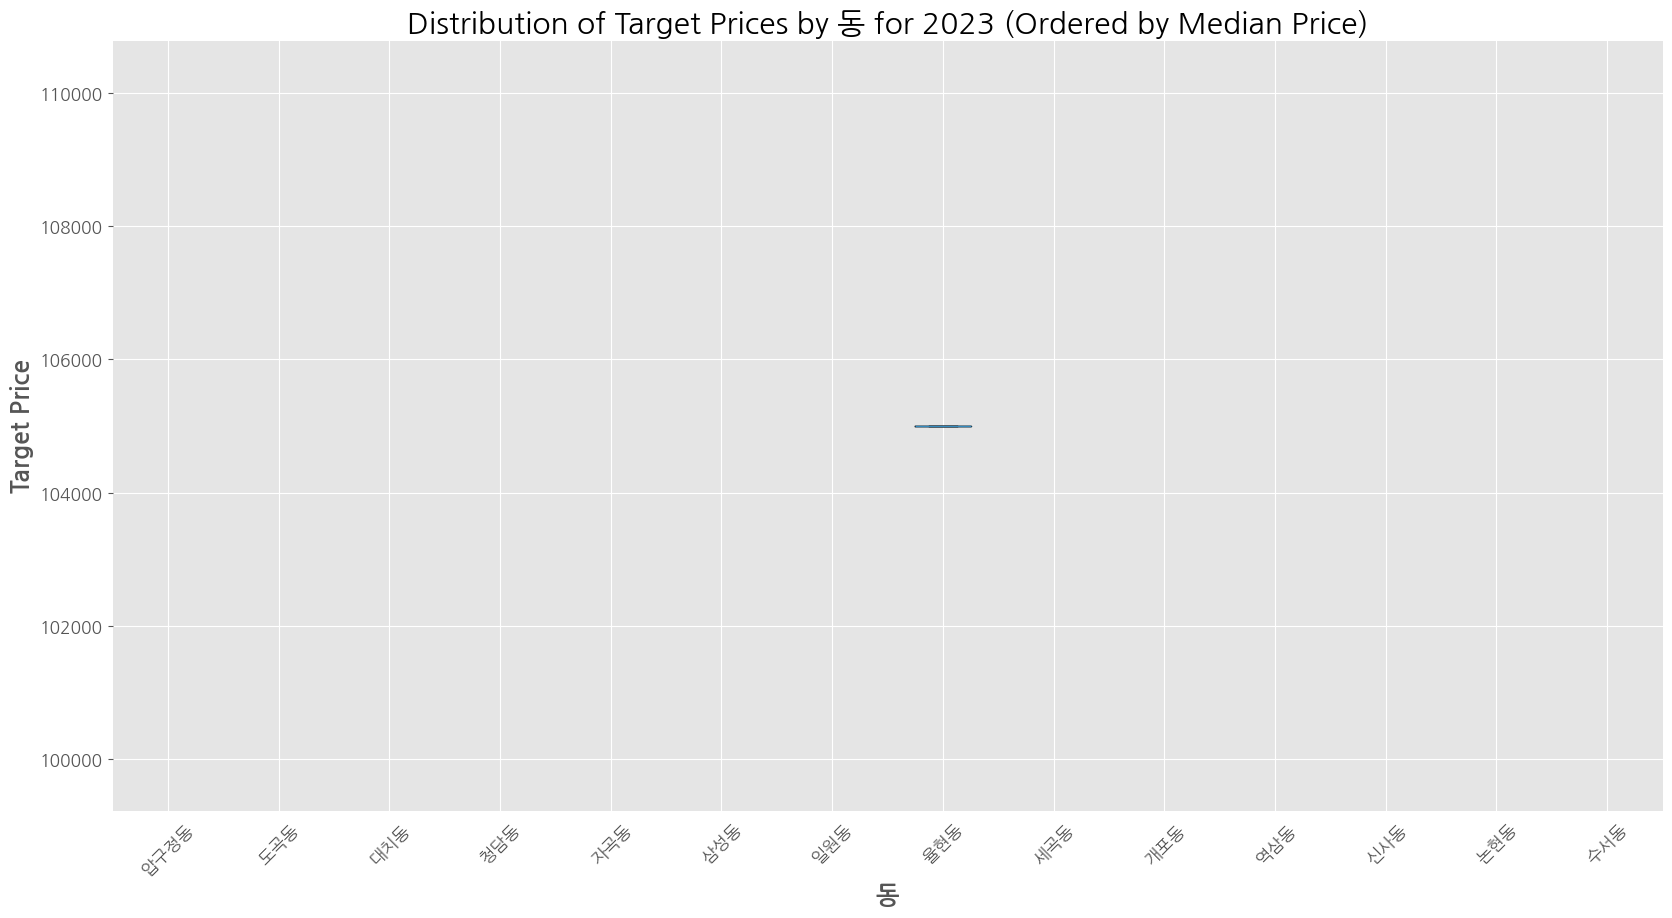

In [528]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 준비
train_test['계약년월일'] = pd.to_datetime(train_test['계약년월일'])

# '동'별로 평균 'target'을 계산하고 정렬
filtered = train_test[train_test.구 =='강남구']
median_targets = filtered.groupby('동')['target'].median().sort_values(ascending=False)
sorted_gus = median_targets.index  # 정렬된 '동' 목록

# 각 연도별로 데이터 필터링 및 박스플롯 생성
start_year = 2007
end_year = 2023
for year in range(start_year, end_year + 1):
    year_df = filtered[(filtered['계약년월일'].dt.year == year)]

    # 박스플롯 데이터 준비
    boxplot_data = [year_df[year_df['동'] == gu]['target'] for gu in sorted_gus]

    # 박스플롯 생성
    plt.figure(figsize=(20, 10))
    plt.boxplot(boxplot_data, labels=sorted_gus)
    plt.xticks(rotation=45)  # x축 레이블 회전
    plt.xlabel('동')
    plt.ylabel('Target Price')
    plt.title(f'Distribution of Target Prices by 동 for {year} (Ordered by Median Price)')
    plt.grid(True)
    plt.show()


# prep --> 버전 안맞아서 실패

In [ ]:
from dataprep.eda import create_report

report = create_report(train_test)
report.save('train_test.html')
report.show_browser()
report.show()

# 결측치

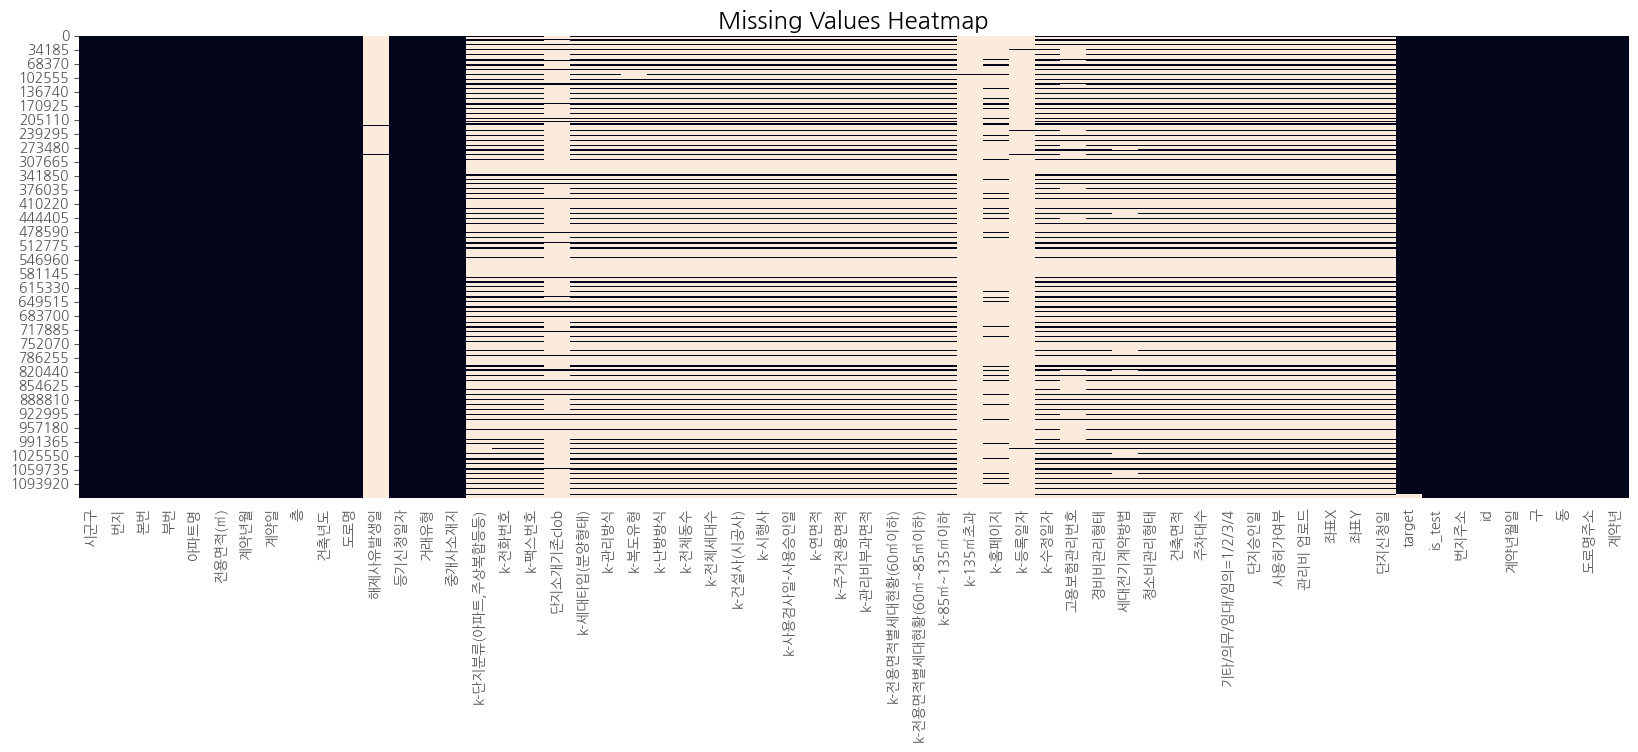

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# 결측치 히트맵 생성
plt.figure(figsize=(20, 6))  # 가로 16인치, 세로 6인치로 설정
sns.heatmap(train_test.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()


In [21]:
train_test[['해제사유발생일','등기신청일자','계약년월일']]

,해제사유발생일,등기신청일자,계약년월일
0,NaN,,2017-12-08
1,NaN,,2017-12-22
2,NaN,,2017-12-28
3,NaN,,2018-01-03
4,NaN,,2018-01-08
...,...,...,...
1128089,20230801.0,,2023-07-19
1128090,NaN,,2023-07-25
1128091,NaN,,2023-08-27
1128092,NaN,,2023-09-02
